In [1]:
import networkx as nx
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from simulate_gilllespie_interface import gillespie_simulate
from plot_module import plot_ODE, plot_gillespie, plot_network
from sim_from_network import names_from_network, gillespie_reaction_dict_from_network, dataframes_from_network, ODE_from_network

In [2]:
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)

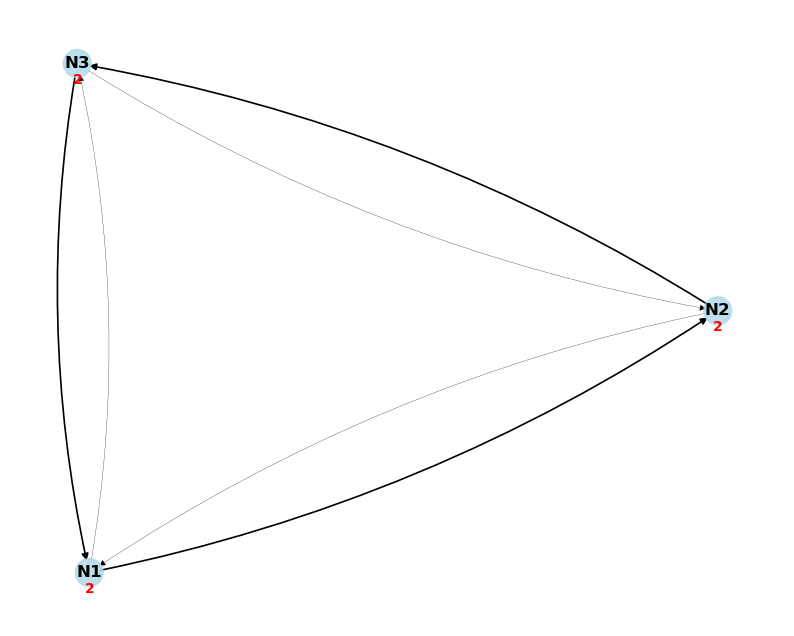

In [11]:
G = nx.DiGraph()

G.add_node('N1', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N2', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
G.add_node('N3', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)

G.add_edge('N1', 'N2', rate=0.06)
G.add_edge('N2', 'N3', rate=0.06)
G.add_edge('N3', 'N1', rate=0.06)

G.add_edge('N2', 'N1', rate=0.01)
G.add_edge('N3', 'N2', rate=0.01)
G.add_edge('N1', 'N3', rate=0.01)

plot_network(G)

start_state = [190, 20, 190, 20, 190, 20]

In [4]:
VARS, COMP = names_from_network(G)

In [12]:
ODE_model = ODE_from_network(G)

> Code for ODE model:

global ODE_model
def ODE_model(t,z):
	N1_wt, N1_mt, N2_wt, N2_mt, N3_wt, N3_mt = z
	return [
		(N1_wt*((0.07 + 0.1*(200-N1_wt-(0.5*N1_mt)))-(0.07)-(0.07)))+(N2_wt*0.01)+(N3_wt*0.06), # ΔN1_wt\Δt
		(N1_mt*((0.07 + 0.1*(200-N1_wt-(0.5*N1_mt)))-(0.07)-(0.07)))+(N2_mt*0.01)+(N3_mt*0.06), # ΔN1_mt\Δt
		(N2_wt*((0.07 + 0.1*(200-N2_wt-(0.5*N2_mt)))-(0.07)-(0.07)))+(N1_wt*0.06)+(N3_wt*0.01), # ΔN2_wt\Δt
		(N2_mt*((0.07 + 0.1*(200-N2_wt-(0.5*N2_mt)))-(0.07)-(0.07)))+(N1_mt*0.06)+(N3_mt*0.01), # ΔN2_mt\Δt
		(N3_wt*((0.07 + 0.1*(200-N3_wt-(0.5*N3_mt)))-(0.07)-(0.07)))+(N1_wt*0.01)+(N2_wt*0.06), # ΔN3_wt\Δt
		(N3_mt*((0.07 + 0.1*(200-N3_wt-(0.5*N3_mt)))-(0.07)-(0.07)))+(N1_mt*0.01)+(N2_mt*0.06), # ΔN3_mt\Δt
		]


In [6]:
sol = integrate.solve_ivp(ODE_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

> Final counts of mt and wt in each compartment:
N1_wt	190.0	
N1_mt	20.0	
N2_wt	190.0	
N2_mt	20.0	
N3_wt	190.0	
N3_mt	20.0	

> Final effective population sizes in each compartment:
N1	200.0	
N2	200.0	
N3	200.0	


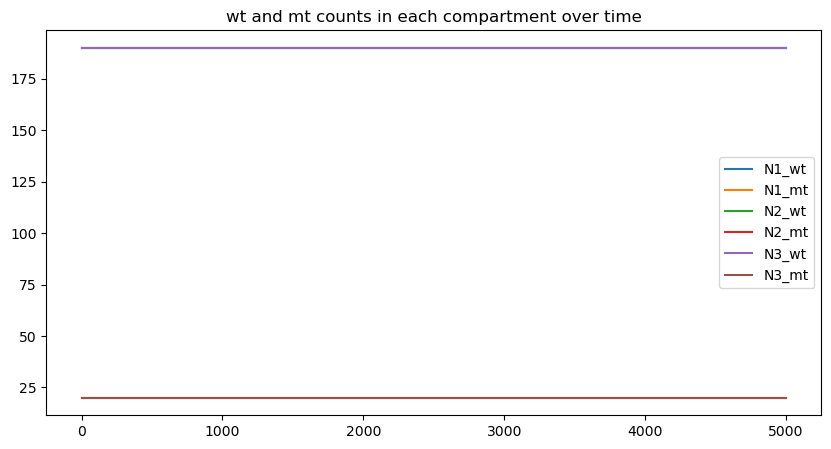

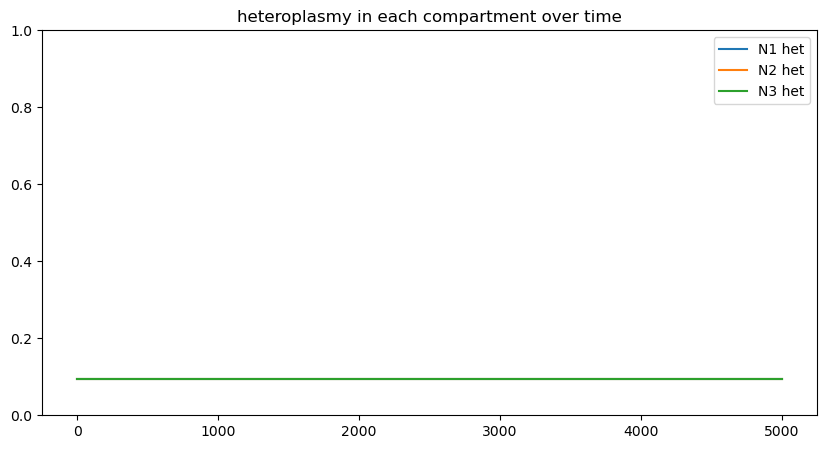

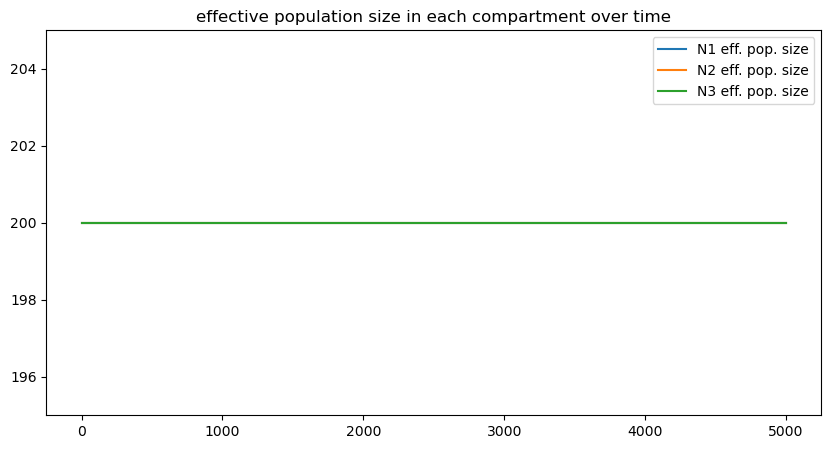

In [7]:
plot_ODE(results, TIME_POINTS, 0.5, VARS, COMP)

In [8]:
dict_reactions = gillespie_reaction_dict_from_network(G)

> Reactions:
reaction #	update to system	rate	state index
0		[1, 0, 0, 0, 0, 0]	-1	0
1		[0, 1, 0, 0, 0, 0]	-1	1
2		[0, 0, 1, 0, 0, 0]	-1	2
3		[0, 0, 0, 1, 0, 0]	-1	3
4		[0, 0, 0, 0, 1, 0]	-1	4
5		[0, 0, 0, 0, 0, 1]	-1	5
6		[-1, 0, 0, 0, 0, 0]	0.07	0
7		[0, -1, 0, 0, 0, 0]	0.07	1
8		[0, 0, -1, 0, 0, 0]	0.07	2
9		[0, 0, 0, -1, 0, 0]	0.07	3
10		[0, 0, 0, 0, -1, 0]	0.07	4
11		[0, 0, 0, 0, 0, -1]	0.07	5
12		[-1, 0, 1, 0, 0, 0]	0.06	0
13		[0, -1, 0, 1, 0, 0]	0.06	1
14		[0, 0, -1, 0, 1, 0]	0.06	2
15		[0, 0, 0, -1, 0, 1]	0.06	3
16		[1, 0, 0, 0, -1, 0]	0.06	4
17		[0, 1, 0, 0, 0, -1]	0.06	5

> Dynamic birth rates:
reaction #s	par(c_b, mu, nss, delta)	state index
0, 1		[0.1, 0.07, 200, 0.5]		0
2, 3		[0.1, 0.07, 200, 0.5]		2
4, 5		[0.1, 0.07, 200, 0.5]		4


In [9]:
REPLICATES = 100
replicate_results = np.zeros((REPLICATES, len(VARS), TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(gillespie_simulate(dict_reactions, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")

simulating...


(3, 500)
> Final mean counts of mt and wt in each compartment:
N1_wt	149.92	
N1_mt	100.75	
N2_wt	150.53	
N2_mt	99.86	
N3_wt	149.83	
N3_mt	101.02	

> Final mean heteroplasmy in each compartment:
N1	0.2851	
N2	0.2839	
N3	0.2862	

> Final mean effective population sizes in each compartment:
N1	200.295	
N2	200.46	
N3	200.34	

> Change in mean heteroplasmy: 
start: 0.0952
final: 0.285
delta: 0.1898


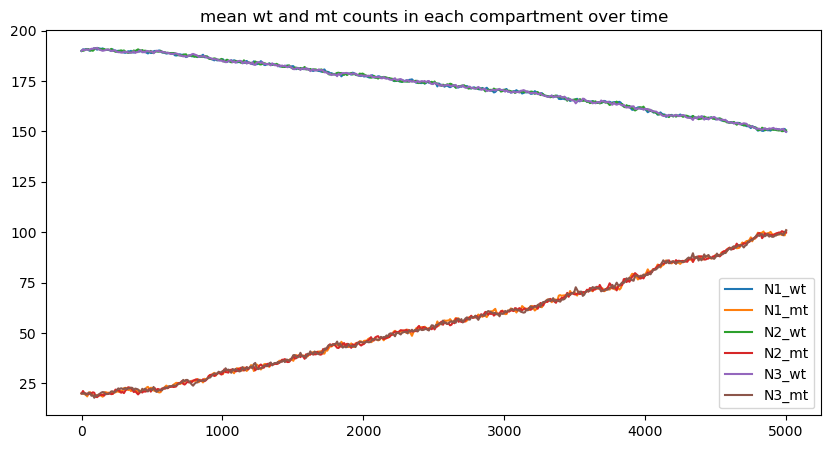

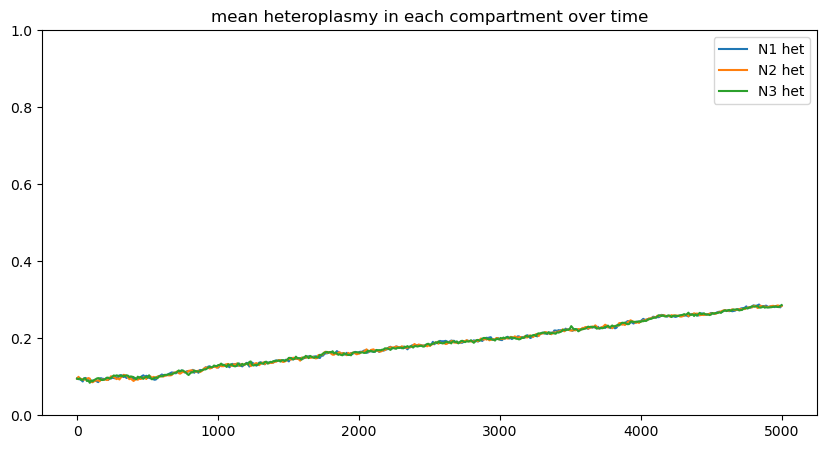

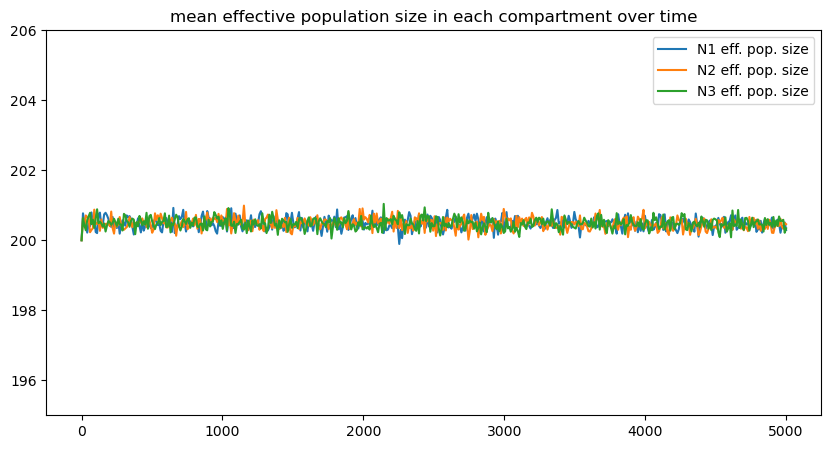

In [10]:
plot_gillespie(replicate_results, TIME_POINTS, 0.5, VARS, COMP)